In [1]:
import pandas as pd

data = pd.read_csv("Data_PCA.csv")
data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Target
0,-0.314242,-0.205719,-0.028824,0.206659,0.012864,-0.874508,0.387179,0.010646,Dropout
1,-0.470709,-0.329179,0.884960,-0.093840,-0.083021,0.226558,0.106516,-0.184132,Graduate
2,-0.396169,0.580298,0.717272,0.092688,0.067955,-0.065536,-0.096558,-0.204557,Dropout
3,-0.130125,0.273844,-0.174658,-0.023552,-0.576278,0.067090,-0.072535,-0.123530,Graduate
4,-0.131716,0.229628,-0.067836,-0.505245,-0.335535,-0.094679,0.105542,0.325822,Graduate
...,...,...,...,...,...,...,...,...,...
4419,-0.276222,-0.514504,-0.105317,-0.246347,0.491042,0.030594,-0.111448,-0.049411,Graduate
4420,-0.528528,-0.238030,0.820748,0.271141,0.030093,0.218110,-0.039184,-0.136250,Dropout
4421,0.814815,0.084677,0.172297,-0.317228,-0.250588,-0.060601,-0.045802,0.100848,Dropout
4422,0.810934,0.170534,0.080124,0.148968,-0.501787,-0.070562,0.011215,-0.056446,Graduate


In [3]:
print(data['PC1'].std())
print(data['PC1'].mean())

0.44516422855016563
5.741840597518892e-17


In [4]:
print(data['PC2'].std())
print(data['PC2'].mean())

0.36350721009469966
9.636655548283456e-18


In [2]:
features = data.drop(['Target'], axis = 1)

target = data['Target']
target.value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

Checking whether target is balanced

<function matplotlib.pyplot.show(close=None, block=None)>

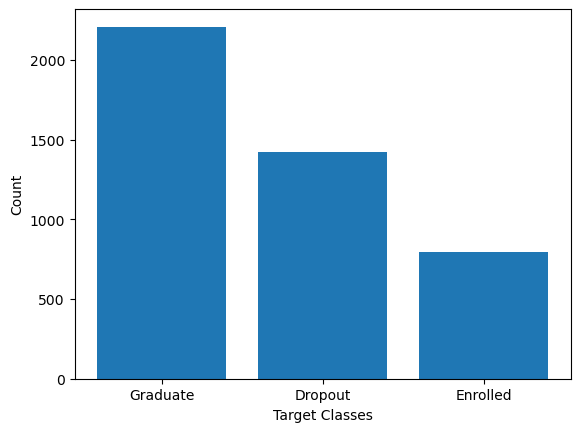

In [3]:
import matplotlib.pyplot as plt
count_class = target.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.show

Using SMOTE to blanace the data

In [4]:
from imblearn.over_sampling import SMOTE

#taking the minority approach to generate synthetic values for the minority class
smote = SMOTE(sampling_strategy="minority", random_state=42) #setting the seed for reproducibility

features_bal,target_bal = smote.fit_resample(features, target)
target.value_counts()

#repeat again since there are three classes and 2 are undersampled
features_bal,target_bal = smote.fit_resample(features_bal, target_bal)
target_bal.value_counts()

Dropout     2209
Graduate    2209
Enrolled    2209
Name: Target, dtype: int64

Now that the dataset is balanced, need to split the data into training (70%), testng (20%) and validating (10%) datasets.

In [5]:
from sklearn.model_selection import train_test_split

#training data is 70%, 30% of dataset is a temporary one which will be further split
X_train, X_temp, y_train, y_temp = train_test_split(features_bal, target_bal, test_size = 0.3, random_state = 42) 

#splitting the temp dataset into validation and testing data
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=10/30, random_state=42)

#checking split
print("Total number of datapoints: "+str(features_bal.shape[0]))
print("Number of datapoints in the training set: "+str(X_train.shape[0]))
print("Number of datapoints in the validation set: "+str(X_val.shape[0]))
print("Number of datapoints in the test set: "+str(X_test.shape[0]))


Total number of datapoints: 6627
Number of datapoints in the training set: 4638
Number of datapoints in the validation set: 663
Number of datapoints in the test set: 1326


**K-nearest neighbours (KNN) Algorithm**

To ensure that all features equally contribute to the computation of distances, when KNN is applied, we need to standardise them

In [6]:
from sklearn.preprocessing import StandardScaler
import numpy as np

#fit the standardscaler on the training data and use it to transform the validation and test data
#learn the statistics from the training data - mean and stdev of the training data to scale the training, valid and test data as well
scaler = StandardScaler()
#does the fit and transform in one step
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

for i in range(X_train.shape[1]):
  print("feature: %2d - Mean: %.1f - Std: %.3f - Min: %.3f - Max: %.3f" % (i+ 1,  np.mean(X_train[:,i]), np.std(X_train[:,i]), np.min(X_train[:,i]), np.max(X_train[:,i])))

feature:  1 - Mean: 0.0 - Std: 1.000 - Min: -1.320 - Max: 2.153
feature:  2 - Mean: -0.0 - Std: 1.000 - Min: -2.073 - Max: 2.428
feature:  3 - Mean: -0.0 - Std: 1.000 - Min: -1.680 - Max: 3.752
feature:  4 - Mean: 0.0 - Std: 1.000 - Min: -2.801 - Max: 2.506
feature:  5 - Mean: 0.0 - Std: 1.000 - Min: -1.962 - Max: 2.613
feature:  6 - Mean: 0.0 - Std: 1.000 - Min: -4.303 - Max: 4.950
feature:  7 - Mean: 0.0 - Std: 1.000 - Min: -1.761 - Max: 8.124
feature:  8 - Mean: -0.0 - Std: 1.000 - Min: -1.882 - Max: 6.845


Chosing k based on the accuracy of the predictor on the validation data, and trying three different metrics

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#try these values of k
num_neighbours = [1, 3, 5, 7, 9, 11, 13, 15, 21, 27, 31, 45, 65, 131]
#store performances for each of the classifiers in this empty list
performance_euclidean = []

for k in num_neighbours:
  clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  clf.fit(X_train, y_train)
  
  #make predictions on validation and check performance on it
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  performance_euclidean.append(acc)

performance_manhattan = []
for k in num_neighbours:
  clf = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  clf.fit(X_train, y_train)
  
  #make predictions on validation and check performance on it
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  performance_manhattan.append(acc)


performance_cosine = []
for k in num_neighbours:
  clf = KNeighborsClassifier(n_neighbors=k, metric='cosine')
  clf.fit(X_train, y_train)
  
  #make predictions on validation and check performance on it
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  performance_cosine.append(acc)


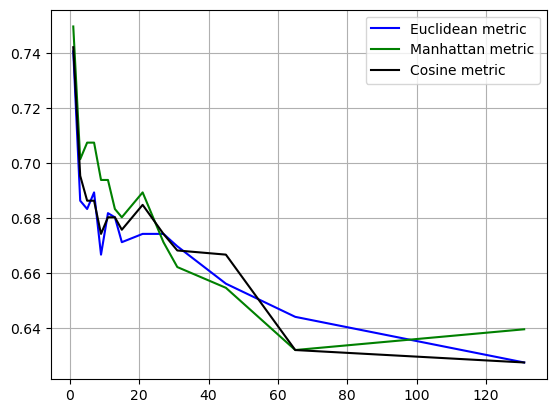

In [8]:
plt.plot(num_neighbours, performance_euclidean, '-b', label = 'Euclidean metric')
plt.plot(num_neighbours, performance_manhattan, '-g', label = 'Manhattan metric')
plt.plot(num_neighbours, performance_cosine, '-k', label = 'Cosine metric')
plt.grid(True)
plt.legend()

k=1 makes sense, a good approach is to start off with k = sqrt(n)/2 - sqrt(8)/2 ~ 1.4

Although, k=1 is usually a case for overfitting, but with the few features we have it might make sense

keeping k=1, now we can make predictions on the test data, at the moment checking also the metric

In [9]:
from sklearn.metrics import classification_report

clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf.fit(X_train, y_train)
#validation set was used to find number of k
#test set is completely unseens
y_pred = clf.predict(X_test)
#acc = accuracy_score(y_test, y_pred)

#print("The performance of the KNN is: %.2f"%(acc))

print("\nClassification Report for Manhattan Metric:")
print(classification_report(y_test, y_pred))


Classification Report for Manhattan Metric:
              precision    recall  f1-score   support

     Dropout       0.83      0.81      0.82       463
    Enrolled       0.73      0.83      0.78       432
    Graduate       0.80      0.71      0.75       431

    accuracy                           0.78      1326
   macro avg       0.79      0.78      0.78      1326
weighted avg       0.79      0.78      0.78      1326



changing for euclidian metric

In [10]:
clf = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report for Euclidean Metric:")
print(classification_report(y_test, y_pred))


Classification Report for Euclidean Metric:
              precision    recall  f1-score   support

     Dropout       0.83      0.80      0.81       463
    Enrolled       0.72      0.82      0.77       432
    Graduate       0.79      0.71      0.74       431

    accuracy                           0.78      1326
   macro avg       0.78      0.77      0.77      1326
weighted avg       0.78      0.78      0.78      1326



In [11]:
clf = KNeighborsClassifier(n_neighbors=1, metric='cosine')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report for Cosine Metric:")
print(classification_report(y_test, y_pred))


Classification Report for Cosine Metric:
              precision    recall  f1-score   support

     Dropout       0.83      0.79      0.81       463
    Enrolled       0.73      0.83      0.77       432
    Graduate       0.79      0.71      0.75       431

    accuracy                           0.78      1326
   macro avg       0.78      0.78      0.78      1326
weighted avg       0.78      0.78      0.78      1326



running the manhattan distance again since it is slightly better and keeping that data stored

In [12]:
clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report for Manhattan Metric:")
print(classification_report(y_test, y_pred))


Classification Report for Manhattan Metric:
              precision    recall  f1-score   support

     Dropout       0.83      0.81      0.82       463
    Enrolled       0.73      0.83      0.78       432
    Graduate       0.80      0.71      0.75       431

    accuracy                           0.78      1326
   macro avg       0.79      0.78      0.78      1326
weighted avg       0.79      0.78      0.78      1326



Confusion matrix to show the actual classes vs the predicted classes based on the test data

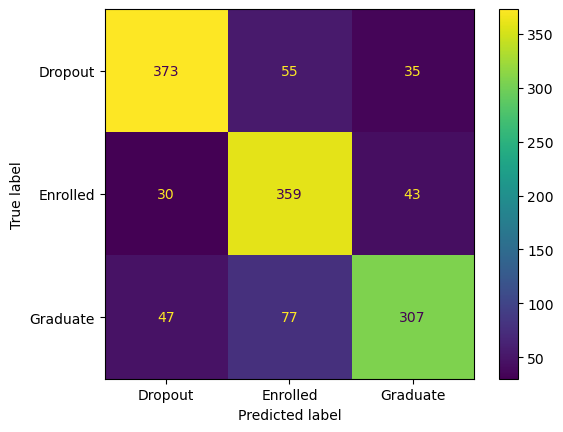

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

Trying the same script but on the reduced dataset of 17 variables + Target variable

In [14]:
data_nonpca = pd.read_csv("Data_selected_pred.csv")
data_nonpca

,marital_status,course,nationality,father_qualif,mother_occ,admission_grade,tuition_fees_up_to_date,scholarship,age_at_enrollment,units_1_credited,units_1_approved,units_2_enrolled,units_2_evaluations,units_2_approved,units_2_no_evaluations,unemployment_rate,inflation_rate,target
0,1,171,1,12,5,127.3,1,0,20,0,0,0,0,0,0,10.8,1.4,Dropout
1,1,9254,1,3,3,142.5,0,0,19,0,6,6,6,6,0,13.9,-0.3,Graduate
2,1,9070,1,37,9,124.8,0,0,19,0,0,6,0,0,0,10.8,1.4,Dropout
3,1,9773,1,37,5,119.6,1,0,20,0,6,6,10,5,0,9.4,-0.8,Graduate
4,2,8014,1,38,9,141.5,1,0,45,0,5,6,6,6,0,13.9,-0.3,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,9773,1,1,5,122.2,1,0,19,0,5,6,8,5,0,15.5,2.8,Graduate
4420,1,9773,105,1,9,119.0,0,0,18,0,6,6,6,2,0,11.1,0.6,Dropout
4421,1,9500,1,37,9,149.5,1,1,30,0,7,8,9,1,0,13.9,-0.3,Dropout
4422,1,9147,1,37,7,153.8,1,1,20,0,5,5,6,5,0,9.4,-0.8,Graduate


In [15]:
features_nonpca = data_nonpca.drop(['target'], axis = 1)

target_nonpca = data_nonpca['target']
target_nonpca.value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: target, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

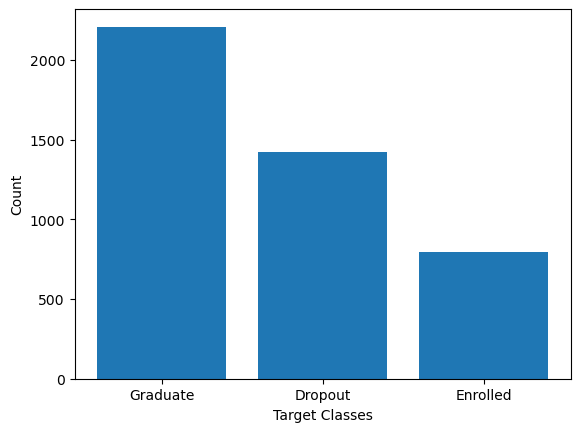

In [16]:
count_class = target_nonpca.value_counts()
plt.bar(count_class.index, count_class.values)
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.show

In [17]:
from imblearn.over_sampling import SMOTE

#setting the seed for reproducibility
smote = SMOTE(sampling_strategy="minority", random_state=42) #taking the minority approach to generate synthetic values for the minority class.

features_nonpca_bal,target_nonpca_bal = smote.fit_resample(features_nonpca, target_nonpca)
target_nonpca.value_counts()

#repeat again since there are three classes and 2 are undersampled
features_nonpca_bal,target_nonpca_bal = smote.fit_resample(features_nonpca_bal, target_nonpca_bal)
target_nonpca_bal.value_counts()

Dropout     2209
Graduate    2209
Enrolled    2209
Name: target, dtype: int64

In [18]:
#training data is 70%, 30% of dataset is a temporary one which will be further split
Xnp_train, Xnp_temp, ynp_train, ynp_temp = train_test_split(features_nonpca_bal, target_nonpca_bal, test_size = 0.3, random_state = 42) 

#splitting the temp dataset into validation and testing data
Xnp_test, Xnp_val, ynp_test, ynp_val = train_test_split(Xnp_temp, ynp_temp, test_size=10/30, random_state=42)

#checking split
print("Total number of datapoints: "+str(features_nonpca_bal.shape[0]))
print("Number of datapoints in the training set: "+str(Xnp_train.shape[0]))
print("Number of datapoints in the validation set: "+str(Xnp_val.shape[0]))
print("Number of datapoints in the test set: "+str(Xnp_test.shape[0]))

Total number of datapoints: 6627
Number of datapoints in the training set: 4638
Number of datapoints in the validation set: 663
Number of datapoints in the test set: 1326


In [19]:
#fit the standardscaler on the training data and use it to transform the validation and test data
#learn the statistics from the training data - mean and stdev of the training data to scale the training, valid and test data as well
scaler = StandardScaler()
#does the fit and transform in one step
Xnp_train = scaler.fit_transform(Xnp_train)

Xnp_val = scaler.transform(Xnp_val)
Xnp_test = scaler.transform(Xnp_test)

for i in range(Xnp_train.shape[1]):
  print("feature: %2d - Mean: %.1f - Std: %.3f - Min: %.3f - Max: %.3f" % (i+ 1,  np.mean(Xnp_train[:,i]), np.std(Xnp_train[:,i]), np.min(Xnp_train[:,i]), np.max(Xnp_train[:,i])))

feature:  1 - Mean: 0.0 - Std: 1.000 - Min: -0.277 - Max: 8.828
feature:  2 - Mean: 0.0 - Std: 1.000 - Min: -4.260 - Max: 0.552
feature:  3 - Mean: 0.0 - Std: 1.000 - Min: -0.130 - Max: 17.267
feature:  4 - Mean: 0.0 - Std: 1.000 - Min: -1.388 - Max: 1.421
feature:  5 - Mean: 0.0 - Std: 1.000 - Min: -0.409 - Max: 6.831
feature:  6 - Mean: -0.0 - Std: 1.000 - Min: -2.262 - Max: 4.580
feature:  7 - Mean: 0.0 - Std: 1.000 - Min: -2.254 - Max: 0.444
feature:  8 - Mean: -0.0 - Std: 1.000 - Min: -0.468 - Max: 2.137
feature:  9 - Mean: -0.0 - Std: 1.000 - Min: -0.821 - Max: 6.283
feature: 10 - Mean: 0.0 - Std: 1.000 - Min: -0.275 - Max: 9.433
feature: 11 - Mean: -0.0 - Std: 1.000 - Min: -1.443 - Max: 7.480
feature: 12 - Mean: 0.0 - Std: 1.000 - Min: -2.949 - Max: 8.311
feature: 13 - Mean: 0.0 - Std: 1.000 - Min: -2.112 - Max: 6.496
feature: 14 - Mean: 0.0 - Std: 1.000 - Min: -1.373 - Max: 5.654
feature: 15 - Mean: -0.0 - Std: 1.000 - Min: -0.210 - Max: 17.406
feature: 16 - Mean: -0.0 - Std: 1

In [20]:
#try these values of k
num_np_neighbours = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
#store performances for each of the classifiers in this empty list
performance_np_euclidean = []

for k in num_np_neighbours:
  clf_np = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
  clf_np.fit(Xnp_train, ynp_train)
  
  #make predictions on validation and check performance on it
  ynp_pred = clf_np.predict(Xnp_val)
  acc_np = accuracy_score(ynp_val, ynp_pred)
  performance_np_euclidean.append(acc_np)

performance_np_manhattan = []
for k in num_np_neighbours:
  clf_np = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
  clf_np.fit(Xnp_train, ynp_train)
  
  #make predictions on validation and check performance on it
  ynp_pred = clf_np.predict(Xnp_val)
  acc_np = accuracy_score(ynp_val, ynp_pred)
  performance_np_manhattan.append(acc_np)


performance_np_cosine = []
for k in num_np_neighbours:
  clf_np = KNeighborsClassifier(n_neighbors=k, metric='cosine')
  clf_np.fit(Xnp_train, ynp_train)
  
  #make predictions on validation and check performance on it
  ynp_pred = clf_np.predict(Xnp_val)
  acc_np = accuracy_score(ynp_val, ynp_pred)
  performance_np_cosine.append(acc_np)


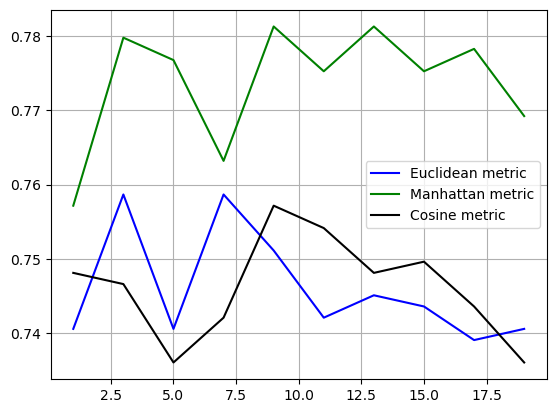

In [21]:
plt.plot(num_np_neighbours, performance_np_euclidean, '-b', label = 'Euclidean metric')
plt.plot(num_np_neighbours, performance_np_manhattan, '-g', label = 'Manhattan metric')
plt.plot(num_np_neighbours, performance_np_cosine, '-k', label = 'Cosine metric')
plt.grid(True)
plt.legend()

Clearly, Euclidean metric works better than the other metrics

In [22]:
performance_np_manhattan[5]==performance_np_manhattan[7]

True

In [23]:
performance_np_manhattan

[0.7571644042232277,
 0.779788838612368,
 0.7767722473604827,
 0.7631975867269984,
 0.7812971342383107,
 0.77526395173454,
 0.7812971342383107,
 0.77526395173454,
 0.7782805429864253,
 0.7692307692307693]

for non pca variables, can keep k=9 with manhattan metric

In [24]:
from sklearn.metrics import classification_report

clf_np = KNeighborsClassifier(n_neighbors=9, metric='manhattan')
clf_np.fit(Xnp_train, ynp_train)
#validation set was used to find number of k
#test set is completely unseens
ynp_pred = clf_np.predict(Xnp_test)

print("\nClassification Report for Manhattan Metric:")
print(classification_report(ynp_test, ynp_pred))


Classification Report for Manhattan Metric:
              precision    recall  f1-score   support

     Dropout       0.87      0.67      0.75       463
    Enrolled       0.67      0.77      0.72       432
    Graduate       0.75      0.83      0.79       431

    accuracy                           0.75      1326
   macro avg       0.76      0.75      0.75      1326
weighted avg       0.77      0.75      0.75      1326



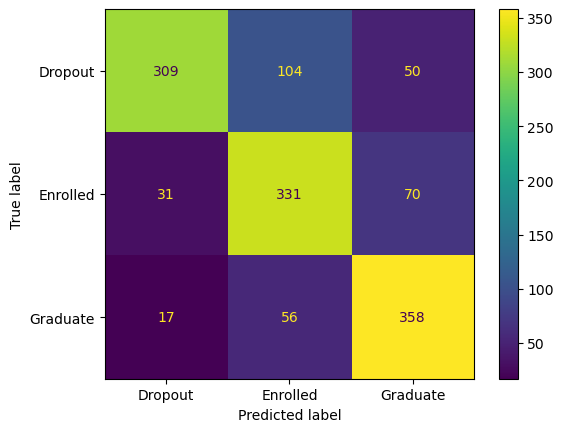

In [25]:
cm_np = confusion_matrix(ynp_test, ynp_pred, labels=clf_np.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_np, display_labels=clf_np.classes_)
disp.plot()
plt.show()

accuracy here is better and without having gone through PCA